# Membuat Classifier nya

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Reshape, LSTM, Input, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import seaborn as sns
from collections import Counter
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


In [122]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 3

# Image Processing

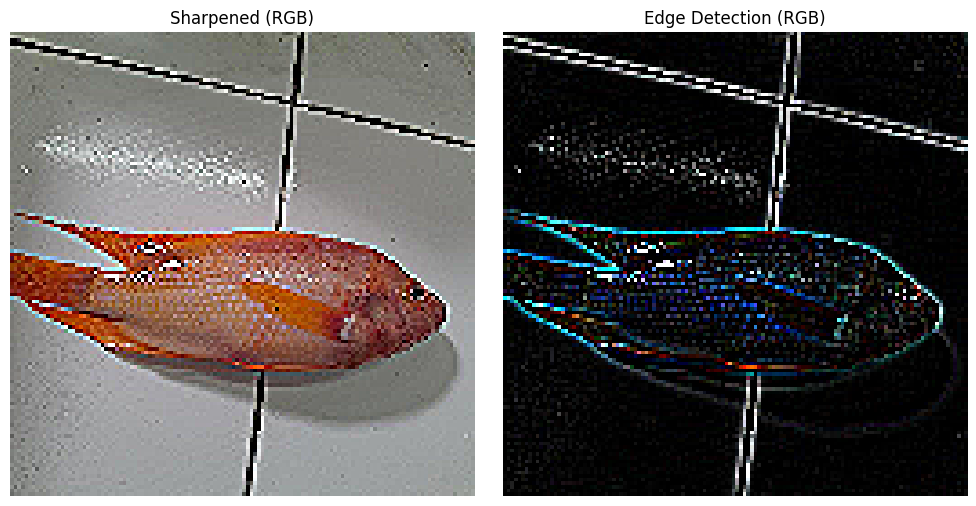

In [123]:
def image_preprocessing(image_path):
    # Baca gambar
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE))

    # Edge detection menggunakan kernel manual
    kernel_edge = np.array([[-1, -1, -1],
                            [-1,  8, -1],
                            [-1, -1, -1]])
    
    edges = cv2.filter2D(img, -1, kernel_edge)

    # Sharpening pada RGB
    kernel_sharpen = np.array([[0, -1, 0],
                            [-1,  5, -1],
                            [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpen)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(sharpened)
    axes[0].set_title('Sharpened (RGB)')
    axes[0].axis('off')
    
    axes[1].imshow(edges)
    axes[1].set_title('Edge Detection (RGB)')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Jalankan fungsi
image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg" 
# image_path = "new_data/WhatsApp Image 2022-11-05 at 22.42.11.jpg" 
image_preprocessing(image_path)




## Membuat dataset generatornya dan mendefenisikan data Generatornya

### Augmentasi Data dan Normalisasi data

In [124]:
# Custom ImageDataGenerator dengan Preprocessing
class CustomImageDataGeneratorWithProcessing(ImageDataGenerator):
    def preprocessing_function(self, img_path):
        return image_preprocessing(img_path, target_size=IMG_SIZE)

In [125]:
# Data Generators
train_datagen = CustomImageDataGeneratorWithProcessing(
    rescale=1.0 / 255.0,
    zoom_range=0.7,
    brightness_range=[0.6, 1.4]
)

validation_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)
test_datagen = CustomImageDataGeneratorWithProcessing(rescale=1.0 / 255.0)

## Mendefinisikan asal folder sumber file berasal

In [126]:
# Directories (Adjust paths as needed)
train_dir = 'dataset/train/'
val_dir = 'dataset/valid/'
test_dir = 'dataset/test/'

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Update NUM_CLASSES based on data
NUM_CLASSES = train_generator.num_classes
labels = train_generator.class_indices.keys()


Found 2721 images belonging to 3 classes.
Found 243 images belonging to 3 classes.
Found 99 images belonging to 3 classes.


In [127]:
labels

dict_keys(['mujahir', 'red_devil', 'sepat'])

# Visualisasi Data

Visualisasi data dengan train:


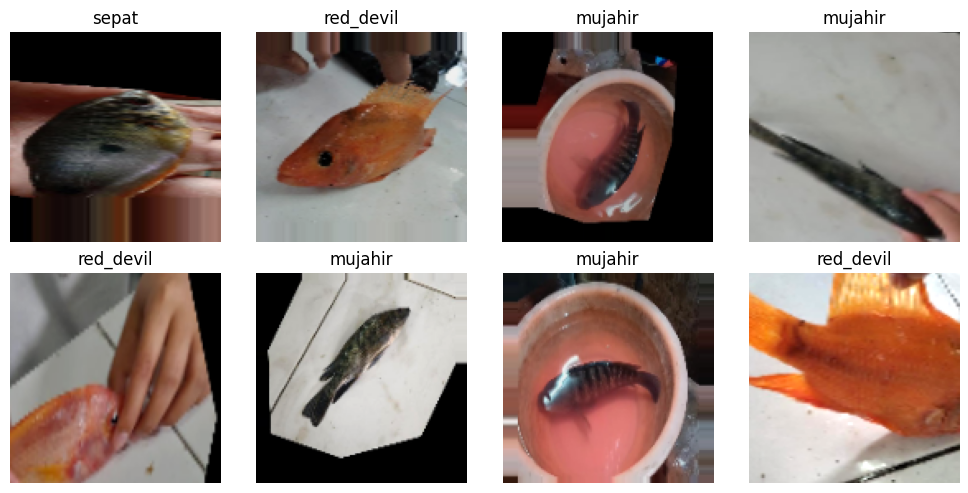

In [128]:
def plot_augmented_images(generator, labels, num_images=8):
    images, labels_batch = next(generator)

    num_images = min(num_images, len(images))  
    labels_decoded = [list(labels)[np.argmax(label)] for label in labels_batch[:num_images]]
    cols = 4  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(cols * 2.5, rows * 2.5)) 

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels_decoded[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

print("Visualisasi data dengan train:")
plot_augmented_images(train_generator, labels)


### Grid Gambar dari Setiap Kelas

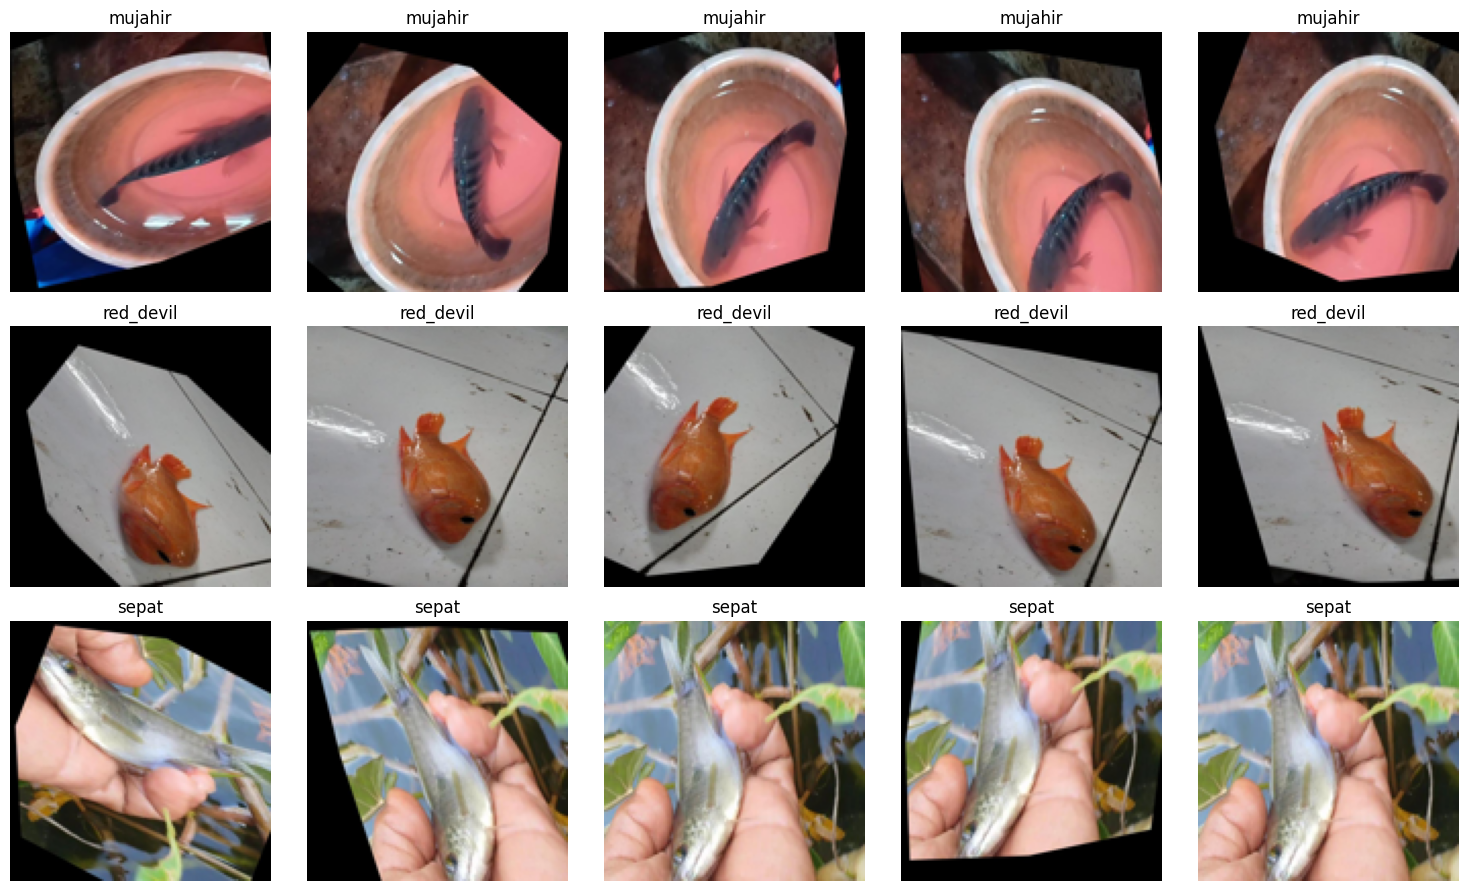

In [129]:
import os
from PIL import Image  
import matplotlib.pyplot as plt

def visualize_samples_per_class(directory, target_size, samples_per_class=5):
    classes = os.listdir(directory)
    plt.figure(figsize=(15, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_file in enumerate(images):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(target_size) 
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples_per_class(train_dir, target_size=IMG_SIZE, samples_per_class=5)


C:\Users\M S I\AppData\Local\Temp\ipykernel_17984\3841989112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


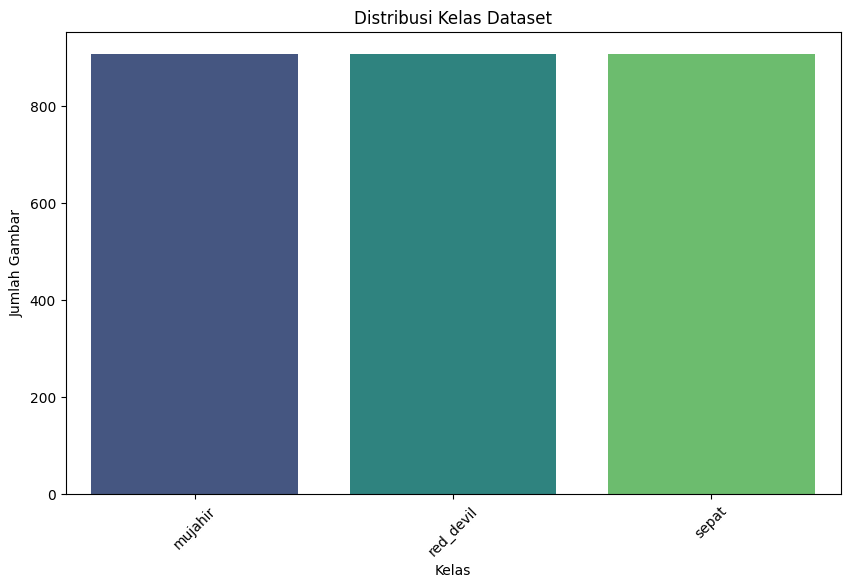

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
import numpy as np

def plot_class_distribution(generator):
    """Visualisasi distribusi kelas"""
    class_counts = Counter(generator.classes) 
    class_names = list(generator.class_indices.keys())
    counts = [class_counts[i] for i in range(len(class_names))]  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")
    plt.title("Distribusi Kelas Dataset")
    plt.ylabel("Jumlah Gambar")
    plt.xlabel("Kelas")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator)


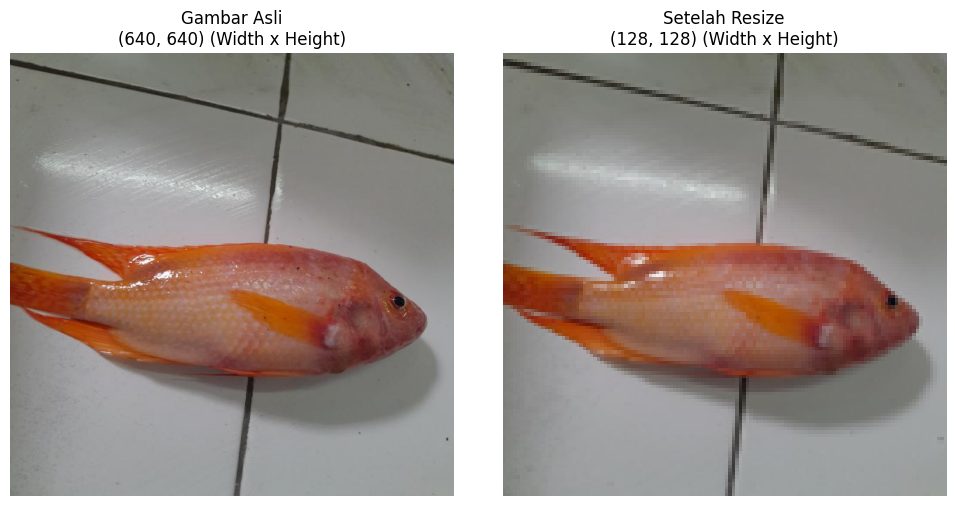

In [131]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_original_and_resized(image_path, target_size):
    try:

        img_original = Image.open(image_path)
        img_original_array = np.array(img_original)

        img_resized = img_original.resize(target_size)
        img_resized_array = np.array(img_resized)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_original_array)
        plt.title(f"Gambar Asli\n{img_original.size} (Width x Height)")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_resized_array)
        plt.title(f"Setelah Resize\n{target_size} (Width x Height)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File tidak ditemukan: {image_path}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# Contoh penggunaan dengan jalur manual
example_image_path = "dataset/valid/red_devil/Red-Devil-244_jpg.rf.a0570767ba2c29e2686282bc1d07d98d.jpg"
if os.path.exists(example_image_path):
    visualize_original_and_resized(example_image_path, IMG_SIZE)
else:
    print("Jalur gambar tidak ditemukan. Pastikan Anda memasukkan jalur yang benar.")


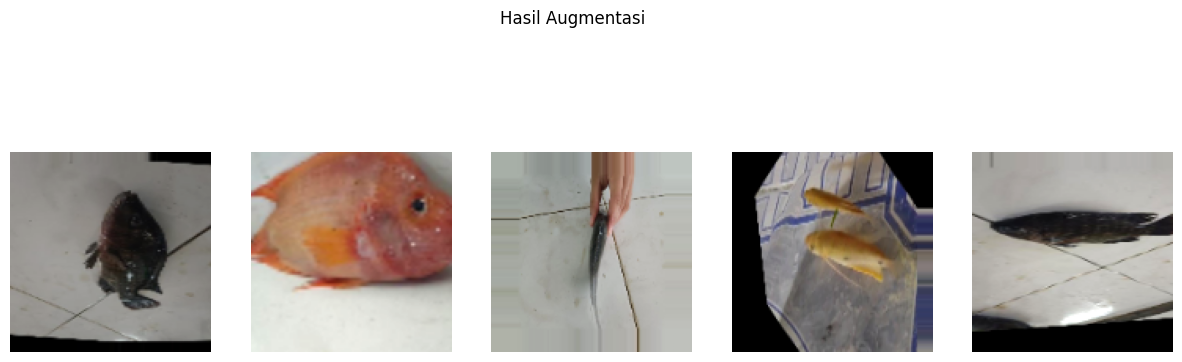

In [132]:
def visualize_augmentation(generator, num_images=5):
    """Visualisasi hasil augmentasi gambar."""
    images, _ = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
    plt.suptitle("Hasil Augmentasi")
    plt.show()

# Contoh penggunaan
visualize_augmentation(train_generator)


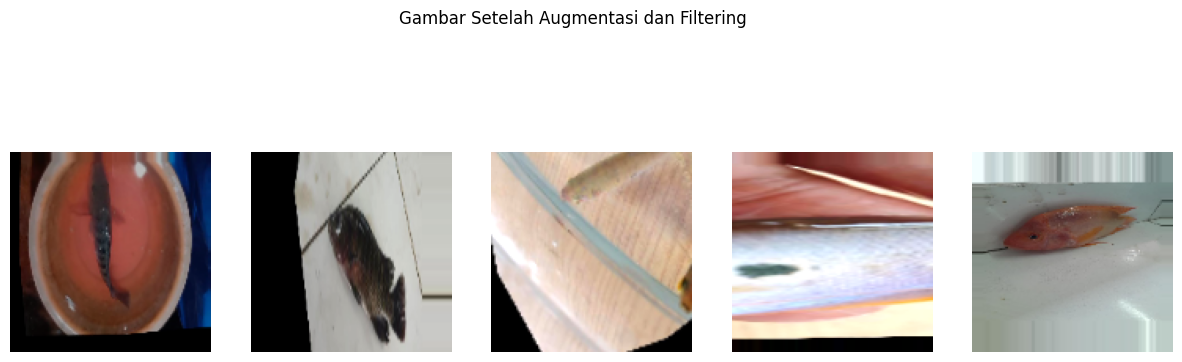

In [133]:
# Fungsi visualisasi
def visualize_augmented_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle("Gambar Setelah Augmentasi dan Filtering")
    plt.show()

# Visualisasikan gambar
visualize_augmented_images(train_generator, num_images=5)

# Mengubah generator data Python Menjadi dataset TensorFlow

agar dapat digunakan dalam pipeline pelatihan, validasi, atau pengujian model secara efisien. Dengan ini, data dapat diproses dalam batch kecil langsung dari generator, mendukung augmentasi, dan tetap hemat memori.

In [134]:
# Define TF Data Generator
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, num_class])
    )
    return tf_generator

train_data = tf_data_generator(train_generator, INPUT_SHAPE)
val_data = tf_data_generator(validation_generator, INPUT_SHAPE)
test_data = tf_data_generator(test_generator, INPUT_SHAPE)


# ANN

In [135]:
# Model
model = Sequential([
    Input(shape=INPUT_SHAPE),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,038,083 (194.69 MB)

 Trainable params: 51,034,115 (194.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Tranfer Learning

## Prebuild model

### Build Base Model

In [136]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
# from tensorflow.keras.optimizers import Adam

# # Load pre-trained ResNet50
# base_model = ResNet50(
#     input_shape=(INPUT_SHAPE),
#     include_top=False,  # Remove the fully connected top layers
#     weights='imagenet'  # Load pre-trained weights from ImageNet
# )

# # Freeze the base model to retain pre-trained weights
# for layer in base_model.layers:
#     layer.trainable = False

# # Add custom layers on top of ResNet50
# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Global Average Pooling
# x = Dropout(0.3)(x)  # Add dropout for regularization
# x = Dense(1024, activation='relu')(x)  # Custom fully connected layer
# x = Dropout(0.3)(x)  # Add another dropout layer
# predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()


In [137]:
from tensorflow.keras.applications import MobileNet

# get base models
base_model = MobileNet(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet',
    classes=NUM_CLASSES,
)

# add to top layer

In [138]:
from tensorflow.keras import layers, Model

# Adding custom layers after ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Apply Global Average Pooling once
x = layers.Dropout(0.2)(x)  # Dropout for regularization
x = layers.Dense(1024, activation="relu")(x)  # Dense layer

x = layers.Dropout(0.2)(x)  # Dropout for regularization
x = layers.Dense(512, activation="relu")(x)  # Another Dense layer

# Output layer
predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Print model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,804,803 (18.33 MB)

 Trainable params: 4,782,915 (18.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Build Base model

In [139]:
# from efficientnet.tfkeras import EfficientNetB1

# # get base models
# base_model = EfficientNetB1(
#     input_shape=INPUT_SHAPE,
#     include_top=False,
#     weights='noisy-student',
#     classes=NUM_CLASSES,
# )

### Add top network layer to models

In [140]:
# from tensorflow.keras import layers,Sequential
# from tensorflow.keras.models import Model

# #Adding custom layers
# x = base_model.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(1024, activation="relu")(x)

# predictions = layers.Dense(NUM_CLASSES, activation="softmax")(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # model.summary()

# # Compile the model
# print('Compiling Model.......')
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# Hyperparameter Tuning

In [141]:
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

In [142]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.001,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [143]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [144]:
# Kompilasi model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [145]:
# # Summary Model
# model.smary()um

In [ ]:
# Training model
history = model.fit(
    train_generator,
    epochs= 25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/25


c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5433 - loss: 7.7541 - val_accuracy: 0.3333 - val_loss: 13.0799 - learning_rate: 0.0100
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8793 - loss: 0.3415 - val_accuracy: 0.5844 - val_loss: 10.3516 - learning_rate: 0.0100
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 80s 911ms/step - accuracy: 0.9304 - loss: 0.2069 - val_accuracy: 0.8848 - val_loss: 0.8728 - learning_rate: 0.0100
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9411 - loss: 0.1987 - val_accuracy: 0.9630 - val_loss: 0.2404 - learning_rate: 0.0100
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9490 - loss: 0.1490 - val_accuracy: 0.9753 - val_loss: 0.2973 - learning_rate: 0.0100
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 85s 975ms/step - accuracy: 0.8999 - loss: 0.3340 - val_accuracy: 0.4938 - val_loss: 3.3330 - learning_rate: 0.0100
Epoch 7/25
39/86 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8957 - loss: 0.3566

In [ ]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 1.0000 - loss: 0.0042  
Test Accuracy: 1.00


In [ ]:
history.history['loss']

[1.7881224155426025,
 0.15838734805583954,
 0.08584000170230865,
 0.4379948377609253,
 0.5285625457763672,
 0.2266075164079666,
 0.19052788615226746,
 0.11812949925661087,
 0.06802276521921158,
 0.07973125576972961,
 0.055896781384944916,
 0.0671476349234581,
 0.08617700636386871,
 0.0729261189699173,
 0.07324483245611191,
 0.054106514900922775,
 0.0505988672375679,
 0.07329242676496506,
 0.06648464500904083,
 0.10279136896133423,
 0.07188538461923599,
 0.08030138909816742,
 0.11731351912021637,
 0.08756556361913681,
 0.0700974091887474]

In [ ]:
history.history['accuracy']

[0.7533994913101196,
 0.9540610313415527,
 0.9750092029571533,
 0.8750459551811218,
 0.796398401260376,
 0.9327453374862671,
 0.950753390789032,
 0.9687615036964417,
 0.984564483165741,
 0.9827269315719604,
 0.984932005405426,
 0.9805218577384949,
 0.981256902217865,
 0.9819918870925903,
 0.9823594093322754,
 0.9852995276451111,
 0.9867695569992065,
 0.9790518283843994,
 0.9827269315719604,
 0.9841969609260559,
 0.9808893799781799,
 0.9830944538116455,
 0.9794193506240845,
 0.9819918870925903,
 0.9852995276451111]

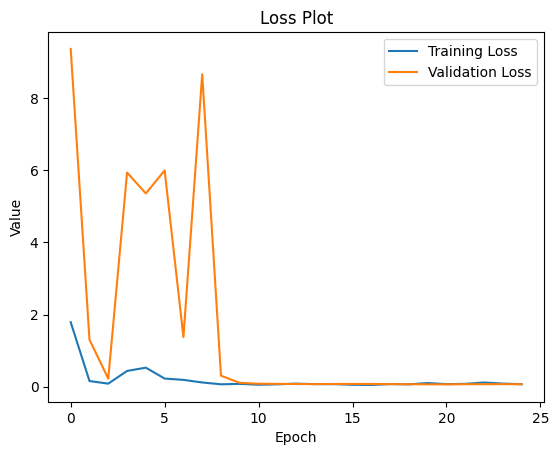

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

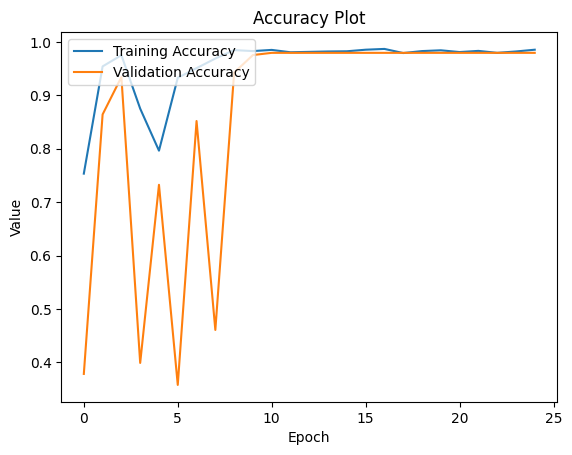

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# plot_learning_rate(history)

In [ ]:
model.save('../model/model_ANN_relu.keras')


# Evaluate Models

In [ ]:
# loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
# print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
# loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
# print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')   

## Pengujian Prediksi dengan Model Checkpoint


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Muat model checkpoint
checkpoint = load_model('../model/my_model.keras')

# Evaluasi model terbaik pada data uji
predictions = checkpoint.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Label sebenarnya dari dataset uji
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Hitung confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('Actual', labelpad=15)
plt.title('Confusion Matrix', pad=15)
plt.show()

# Mendapatkan metrik evaluasi
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Identifikasi prediksi yang salah
misclassified_indices = np.where(true_classes != predicted_classes)[0]

# Menampilkan gambar yang diprediksi salah beserta label yang benar dan yang diprediksi
for idx in misclassified_indices:
    # Ambil nama gambar dari generator
    img_path = train_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[predicted_classes[idx]]
    
    # Muat dan tampilkan gambar
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(32, 128, 128, 3)

In [ ]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.models import load_model

# # Muat model checkpoint
# checkpoint = load_model('../model/my_model.keras')

# # Evaluasi model terbaik pada data uji
# predictions = checkpoint.predict(test_generator)
# predicted_classes = np.argmax(predictions, axis=1)

# # Label sebenarnya dari dataset uji
# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())

# # Hitung confusion matrix
# confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# # Tampilkan confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', vmin=0, vmax=60)
# plt.xlabel('Predicted', labelpad=15)
# plt.ylabel('Actual', labelpad=15)
# plt.title('Confusion Matrix', pad=15)
# plt.show()

# # Mendapatkan metrik evaluasi
# report = classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

# Pengujuian Model

In [ ]:
from tensorflow.keras.models import load_model

# Memuat model SavedModel
loaded_model = load_model('../model/model_ANN_relu.keras')

# Menampilkan ringkasan model untuk memastikan berhasil dimuat
# print(loaded_model.summary())



Predictions for class: mujahir
Processing dataset/test/mujahir\1_mp4-0012_jpg.rf.af408cddf66ccba558575e67d654671a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Processing dataset/test/mujahir\3_mp4-0001_jpg.rf.78c9387cea52f16b363b97e29b2224b4.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing dataset/test/mujahir\3_mp4-0007_jpg.rf.bad24d31e5fd7ac75000cc3bfa89e488.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processing dataset/test/mujahir\3_mp4-0009_jpg.rf.7a6de95452636bd2a742b23d4faf81cd.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/mujahir\5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Processing dataset/test/mujahir\6_mp4-0000_jpg.rf.977683a3c9107b8fb33a5b971cbebd3b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing dataset/test/mujahir\6_mp4-0010_jpg.rf.0d2f29000f8d072d3f12176aa3aa6ef0.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing dataset/test/mujahir\6_mp4-0013_jpg.rf.5e66c2d053fe7b1484bd8

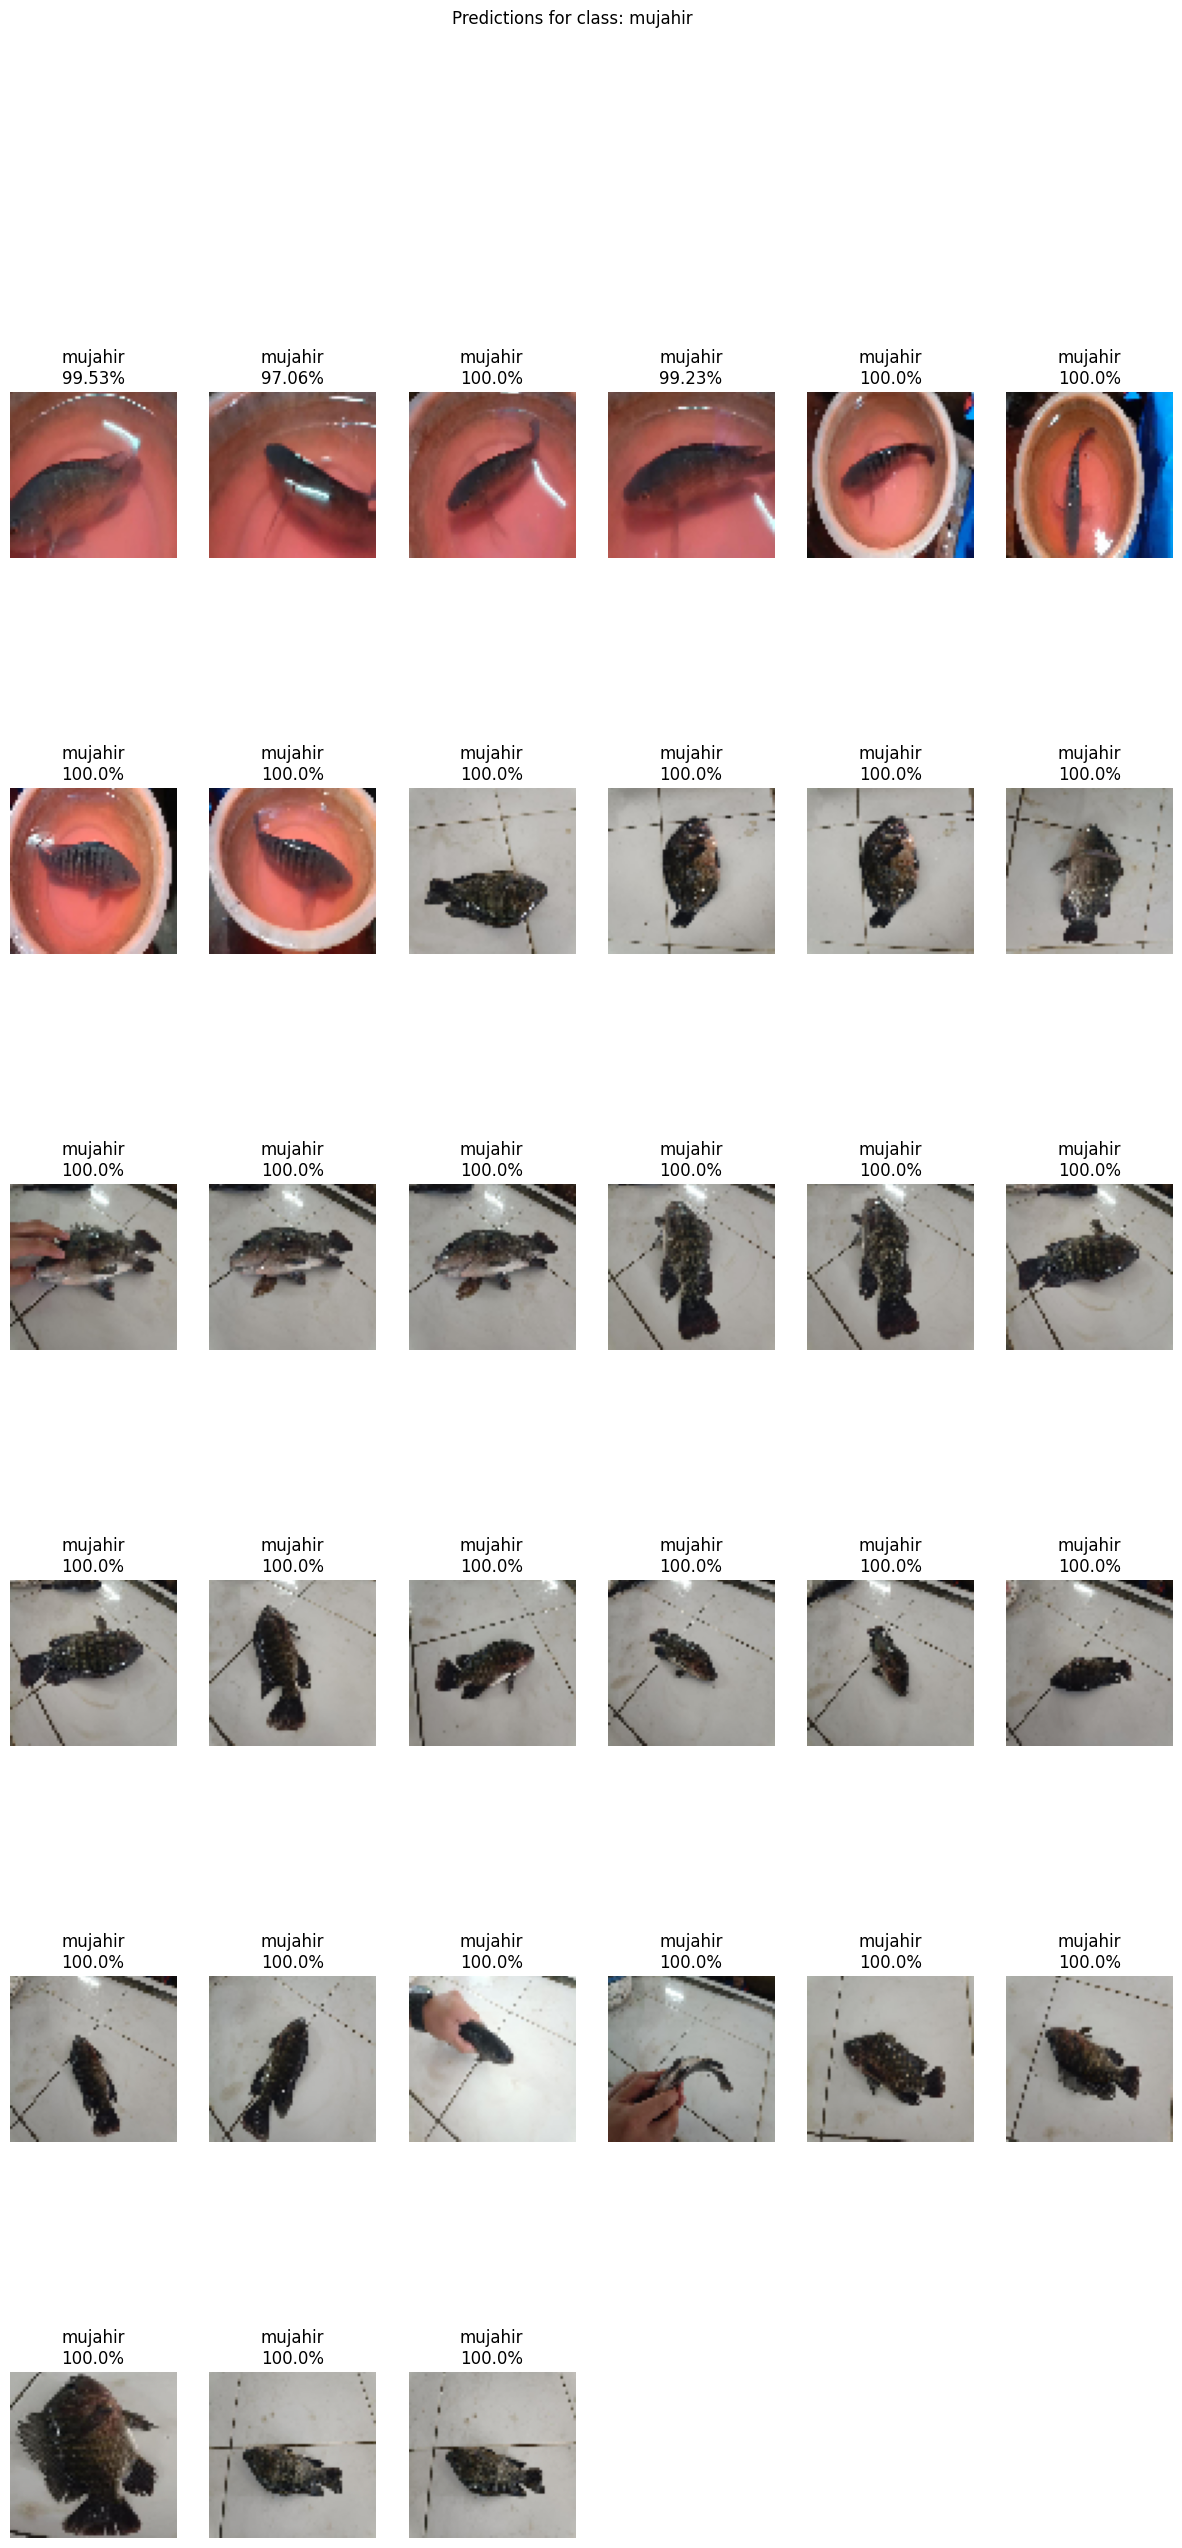


Predictions for class: red_devil
Processing dataset/test/red_devil\Red-Devil-101_png_jpg.rf.d9ed07b6e68c3e93176715b0010a3e33.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing dataset/test/red_devil\Red-Devil-104_png_jpg.rf.f98dbbec37a56d0a59d7e05f5344b89b.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/red_devil\Red-Devil-105_png_jpg.rf.b1efa865a6a211728f411c07d75584a5.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing dataset/test/red_devil\Red-Devil-109_png_jpg.rf.7d9224c65e66461b159bda0982f45d7f.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Processing dataset/test/red_devil\Red-Devil-122_png_jpg.rf.aa35b61ed0b16c3834001f5945a8fc38.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processing dataset/test/red_devil\Red-Devil-132_png_jpg.rf.ae8fcd7bc96bbea6375168be5bcc857c.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing dataset/test/red_devil\Red-Devil-153-_jpg.rf.e300eec181f3255f1b7e705612f6c111.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing

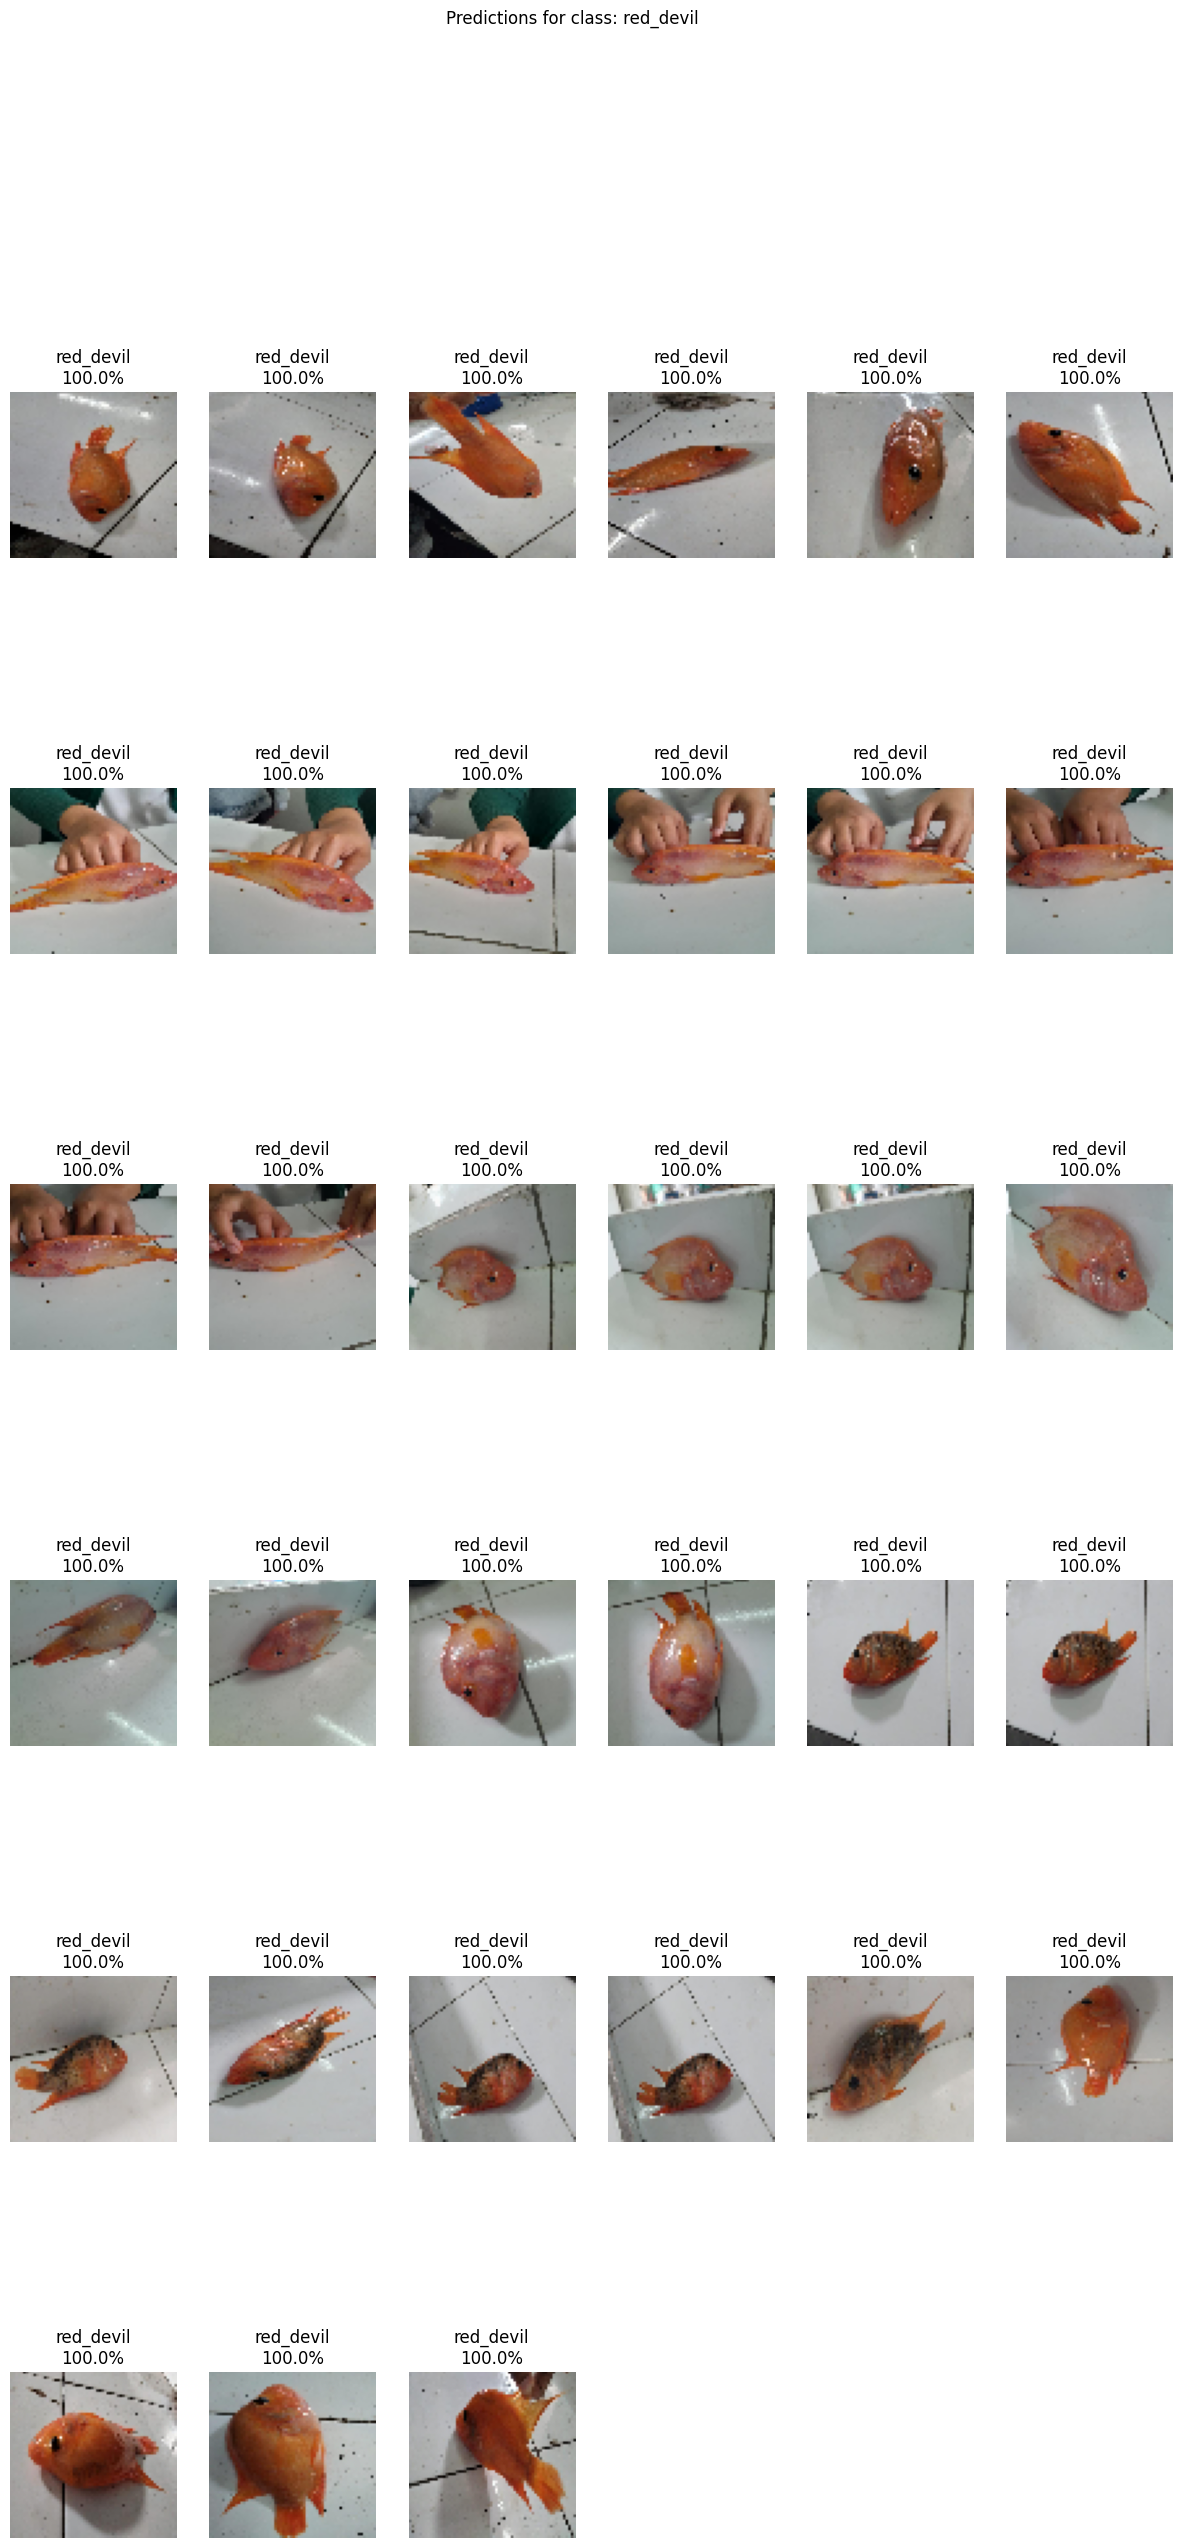


Predictions for class: sepat
Processing dataset/test/sepat\Sepat-104_png_jpg.rf.c8efe00703ee19d384763c8a05f1b4f6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Processing dataset/test/sepat\Sepat-105_png_jpg.rf.e07125ea47295be33fcbe35134c37fc6.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing dataset/test/sepat\Sepat-115_png_jpg.rf.10ef20970ea1c9e1857d1192fa523831.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing dataset/test/sepat\Sepat-117_png_jpg.rf.dfe4e7f8212150cc64d5ddef0e09aaf1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing dataset/test/sepat\Sepat-15_png_jpg.rf.29fb2d9e7813596912e320f4e4017b8a.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Processing dataset/test/sepat\Sepat-16_png_jpg.rf.eeed7dcbc9bb558bc6056c1e9964eb61.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Processing dataset/test/sepat\Sepat-176_jpg.rf.b6caed48284f4995afd08e63b1ee04ce.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Processing dataset/test/sepat\Sepat-184_jpg.rf.ccc8af4b661e42903d254dc517

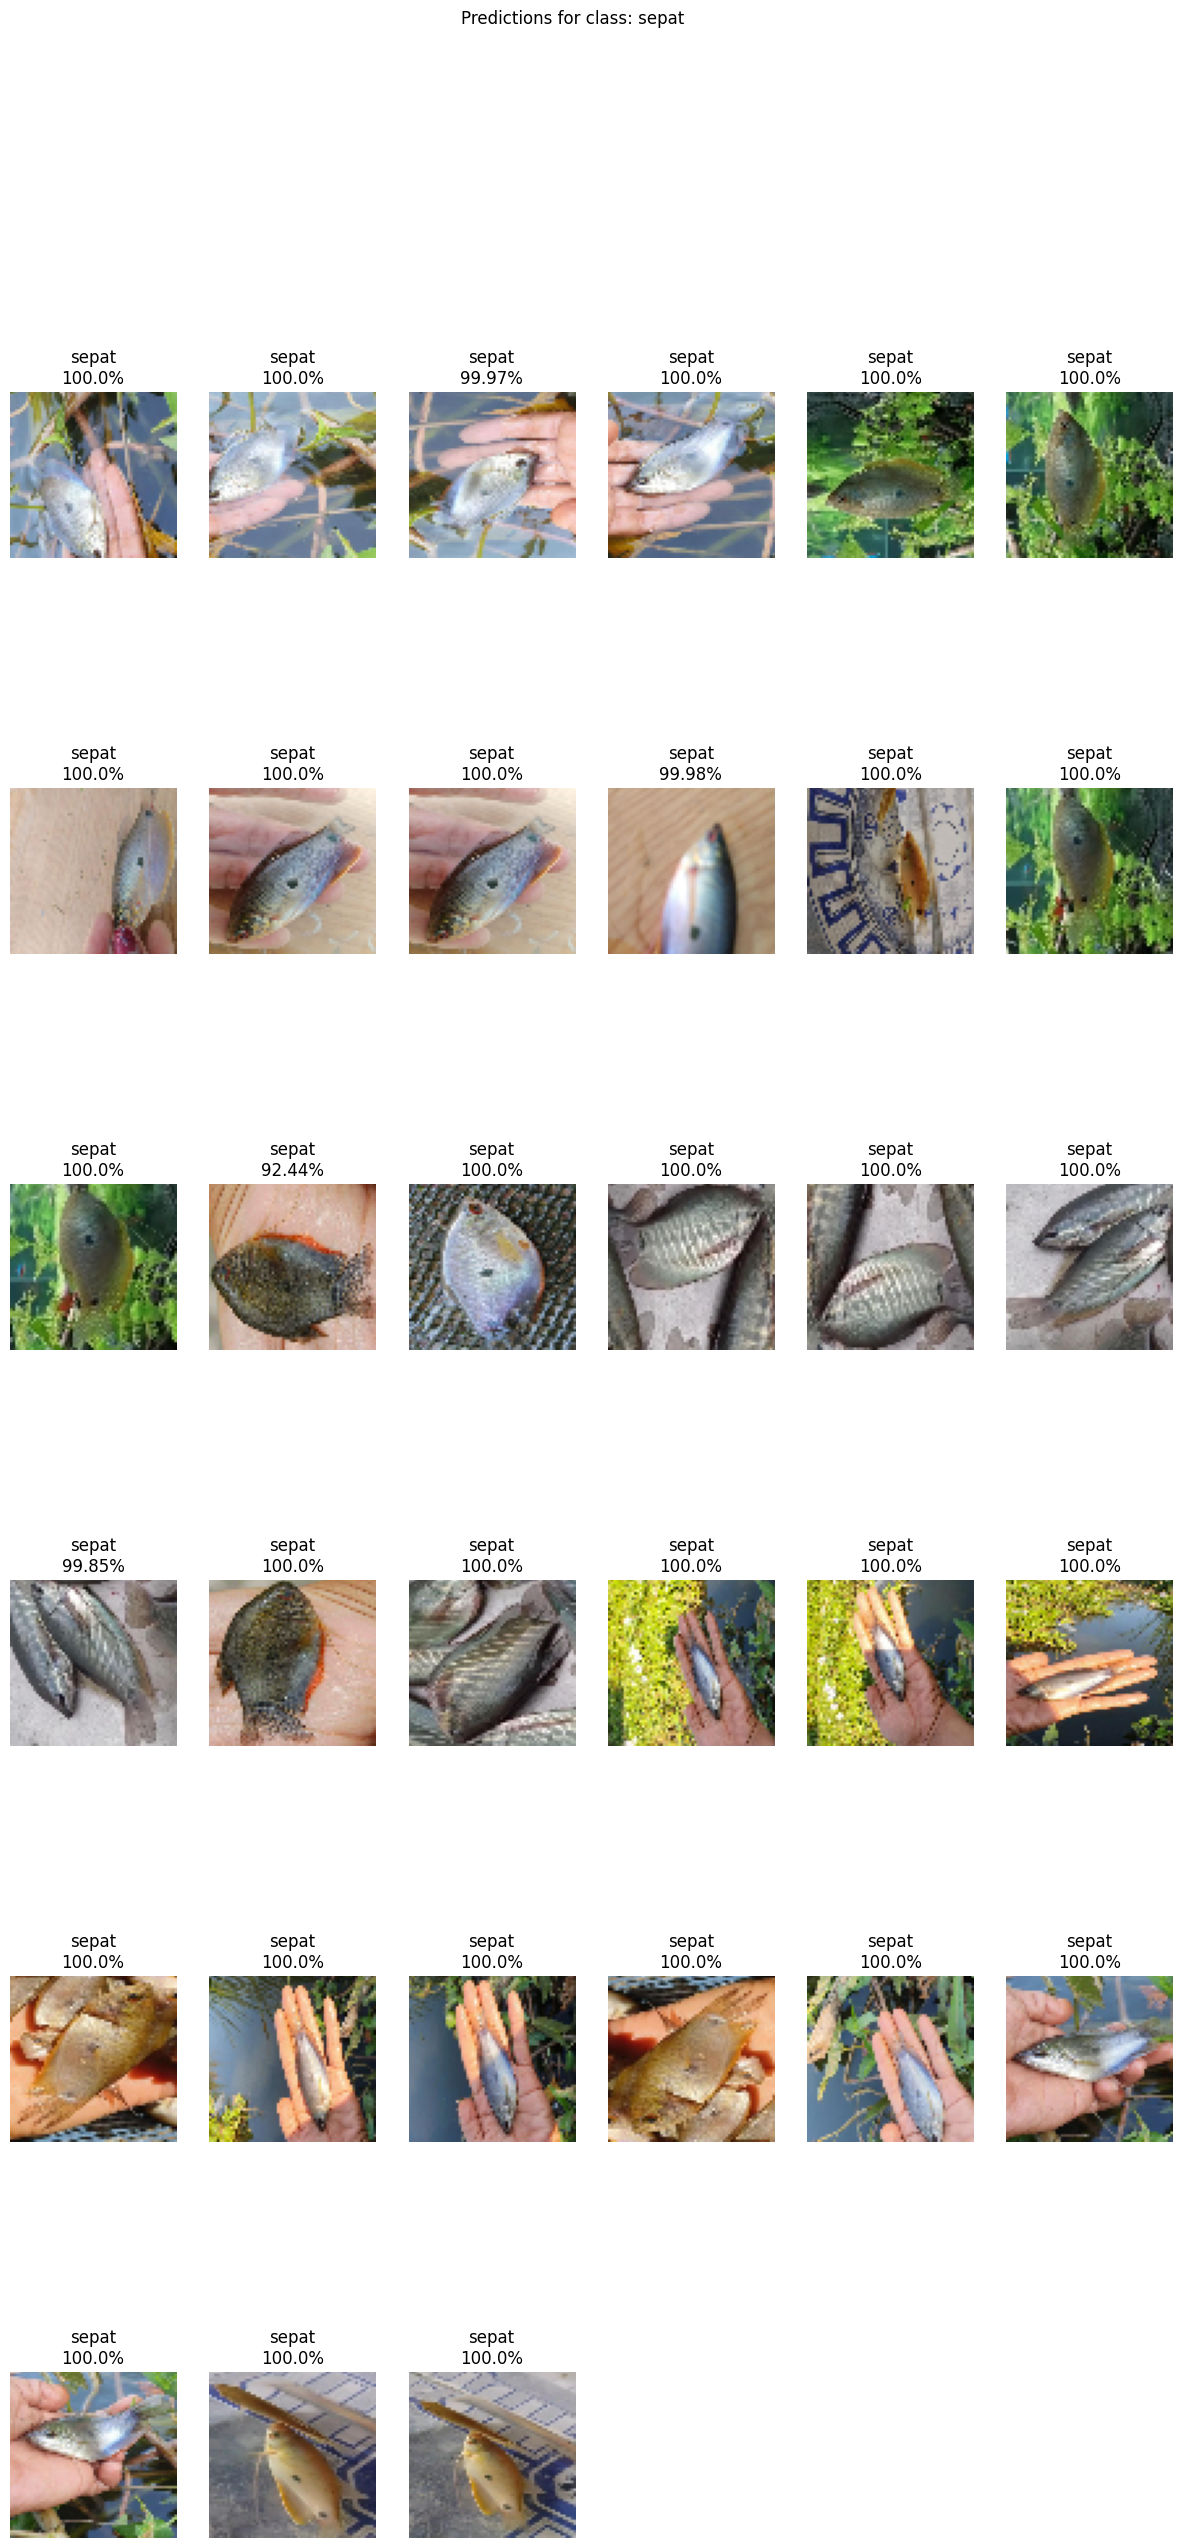

In [ ]:
# Load model
model_path = '../model/my_model.keras' 
loaded_model = load_model(model_path)

# Tentukan ukuran gamba
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=IMG_SIZE)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    return img, label, round(probability * 100, 2)

def predict_images_from_class(class_folder, model):
    images = []
    labels = []
    probabilities = []

    # Ambil semua gambar dari folder kelas tertentu
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            print(f"Processing {img_path}...")
            img, label, probability = predict_image(img_path, model)
            images.append(img)
            labels.append(label)
            probabilities.append(probability)

    return images, labels, probabilities

# Path ke folder dataset
dataset_path = 'dataset/test/'

# Daftar kelas
classes = ['mujahir', 'red_devil', 'sepat']

# Prediksi gambar dari setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    print(f"\nPredictions for class: {class_name}")
    
    images, labels, probabilities = predict_images_from_class(class_folder, loaded_model)
    
    # Tampilkan semua gambar dalam satu plot
    max_images_per_row = 6
    num_rows = (len(images) + max_images_per_row - 1) // max_images_per_row  # Hitung jumlah baris yang diperlukan

    plt.figure(figsize=(15, 5 * num_rows))
    for i in range(len(images)):
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"{labels[i]}\n{probabilities[i]}%")
    
    plt.suptitle(f"Predictions for class: {class_name}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


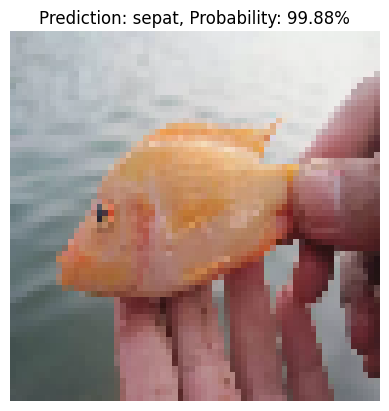

Label: sepat
Probability: 99.88%


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE= (64, 64)

model_path = '../model/model_ANN_relu.keras' 
loaded_model = load_model(model_path)

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  

    # Prediksi
    predictions = model.predict(img_array)
    predict_class = np.argmax(predictions[0]) 
    probability = np.max(predictions[0]) 

    # Map kelas ke label
    labels = ['mujahir', 'red_devil', 'sepat'] 
    label = labels[predict_class]

    # Tampilkan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}, Probability: {round(probability * 100, 2)}%")
    plt.show()

    print(f"Label: {label}")
    print(f"Probability: {round(probability * 100, 2)}%")

# Path ke gambar

img_path = 'new_data/ikan-red-devil-3137882226.webp'

# img_path = 'new_data/Ikan-Sepat.jpg'




# img_path = 'dataset/test/sepat/Sepat-82_png_jpg.rf.e732f4f00346193a2229b0dd0316526e.jpg'
# img_path = 'dataset/test/mujahir/5_mp4-0015_jpg.rf.09ab1aaf6b49190b804d1e3d04cbcbc0.jpg'                      

# img_path = 'new_data/ikan-red-devil-3137882226.jpg'
# img_path = 'new_data/Oreo_nilo_071011-0507_F_jtg.jpg'
# img_path = 'new_data/ikan-mujair1.jpg'
# img_path = 'new_data/qa1  (6).jpg'






# Prediksi gambar
predict_image(img_path, loaded_model)


In [ ]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (244, 224)

# Load model klasifikasi
model_path = '../model/model_ANN_relu.keras' 
loaded_model = load_model(model_path)

# Fungsi Deteksi Objek Menggunakan YOLOv5
def detect_objects_yolo(image_path, model_path='yolov5s'):
    # Load model YOLOv5 pre-trained
    model = torch.hub.load('ultralytics/yolov5', model_path, pretrained=True)
    results = model(image_path)
    detections = results.xyxy[0].cpu().numpy()  # Format: [x_min, y_min, x_max, y_max, confidence, class]
    return detections, results

# Preprocessing dengan Deteksi Objek
def preprocess_with_detection(image_path, target_size=IMG_SIZE):
    # Deteksi objek menggunakan YOLO
    detections, _ = detect_objects_yolo(image_path)
    
    # Crop objek yang terdeteksi berdasarkan deteksi dengan confidence tertinggi
    img = cv2.imread(image_path)
    if len(detections) > 0:
        x_min, y_min, x_max, y_max, confidence, class_id = detections[0]
        img = img[int(y_min):int(y_max), int(x_min):int(x_max)]  # Crop gambar
    else:
        print("No objects detected. Using the full image.")
    
    # Resize gambar ke ukuran target
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah warna ke RGB
    img = cv2.resize(img, target_size)
    
    # Normalisasi gambar ke rentang [0, 1]
    img = img / 255.0
    
    # Expand dimensi untuk input ke model (tambah dimensi batch)
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk Prediksi Gambar
def predict_image(img_path, model):
    try:
        # Preprocessing gambar dengan deteksi objek
        img_array = preprocess_with_detection(img_path, IMG_SIZE)
        
        # Prediksi menggunakan model
        predictions = model.predict(img_array)
        
        # Menampilkan probabilitas untuk setiap kelas
        print(f"Probabilitas untuk setiap kelas: {predictions[0]}")
        
        # Kelas dengan probabilitas tertinggi
        predict_class = np.argmax(predictions[0])
        probability = np.max(predictions[0])

        # Map kelas ke label
        labels = ['mujahir', 'red_devil', 'sepat']
        label = labels[predict_class]

        # Load gambar asli untuk ditampilkan
        img = image.load_img(img_path, target_size=IMG_SIZE)
        
        # Tampilkan gambar dan hasil prediksi
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {label}, Probability: {round(probability * 100, 2)}%")
        plt.show()

        print(f"Label: {label}")
        print(f"Probability: {round(probability * 100, 2)}%")
    except Exception as e:
        print(f"Error during prediction: {e}")

# Path ke gambar baru untuk diuji
img_path = 'new_data/qa1  (6).jpg'

# Prediksi gambar
predict_image(img_path, loaded_model)


Using cache found in C:\Users\M S I/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-6 Python-3.11.5 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\M S I/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probabilitas untuk setiap kelas: [    0.91563   0.0019372    0.082438]
Label: mujahir
Probability: 91.56%


In [ ]:
print(predictions[0])  # Menampilkan semua probabilitas untuk setiap kelas


[    0.99525  0.00053823   0.0042072]


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Path ke model Anda
model_path = '../model/model_ANN_relu.keras'
loaded_model = load_model(model_path)

labels = ['mujahir', 'red_devil', 'sepat'] 

# Fungsi untuk melakukan prediksi
def predict_frame(frame, model):

    resized_frame = cv2.resize(frame, (224, 224)) 
    normalized_frame = resized_frame / 255.0  
    input_frame = np.expand_dims(normalized_frame, axis=0)  # Tambah dimensi batch

    # Prediksi menggunakan model
    predictions = model.predict(input_frame)
    predicted_label = labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100  # Confidence dalam persen
    return predicted_label, confidence

# Inisialisasi kamera
cap = cv2.VideoCapture(0) 

if not cap.isOpened():
    print("Kamera tidak dapat diakses!")
    exit()

print("Menyalakan kamera. Tekan 'q' untuk keluar.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Tidak dapat membaca frame dari kamera.")
        break

    # Lakukan prediksi pada frame saat ini
    predicted_label, confidence = predict_frame(frame, loaded_model)

    # Tampilkan prediksi di frame
    text = f"{predicted_label}: {confidence:.2f}%"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Tampilkan frame
    cv2.imshow("Real-time Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Menyalakan kamera. Tekan 'q' untuk keluar.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step